<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Transformer/TabTransformer/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

CSV_HEADERS = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income_bracket']

train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df_train = pd.read_csv(train_url, header=None, names=CSV_HEADERS)
df_train = df_train.drop(columns=['fnlwgt', 'education_num']).reset_index(drop=True)

cols = df_train.columns
target_cols = ['income_bracket']
numeric_cols = ['capital_gain', 'capital_loss', 'hours_per_week']
categorical_cols = [c for c in cols if c not in target_cols + numeric_cols]

def manipulate_data(df):
    df[numeric_cols] = df[numeric_cols].astype('float32')
    df[categorical_cols] = df[categorical_cols].astype(str)\
        .apply(lambda s: s.str.strip())
    df[target_cols] = df[target_cols].astype(str)\
        .apply(lambda s: s.str.strip().str.replace('.', '', regex=False))
    return df

df_train = manipulate_data(df=df_train)

test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
df_test = pd.read_csv(test_url, header=None, names=CSV_HEADERS, skiprows=1)
df_test = df_test.drop(columns=['fnlwgt', 'education_num']).reset_index(drop=True)
df_test = manipulate_data(df=df_test)

In [20]:
df_train['age'].sort_values().unique()

array(['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82',
       '83', '84', '85', '86', '87', '88', '90'], dtype=object)

AttributeError: Rectangle.set() got an unexpected keyword argument 'order'

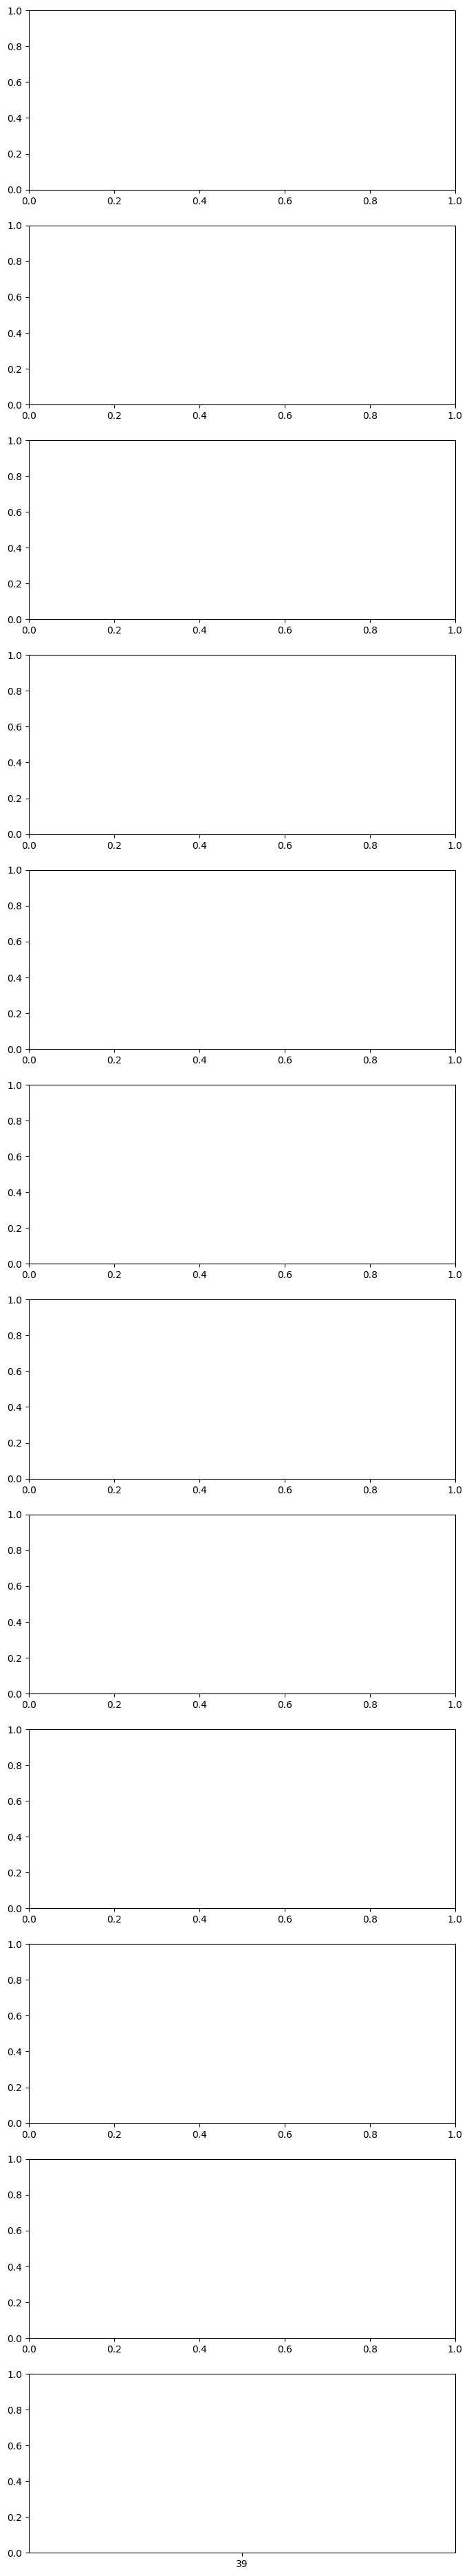

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_x_cols = df_train.columns.drop(target_cols)
ncols = 1
nrows = len(plot_x_cols)//ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 4*nrows))
for ax, col in zip(axes.flatten(), plot_x_cols):
    order = df_train[col].sort_values().unique()
    ax = sns.histplot(data=df_train, x=col, hue=target_cols[0], multiple='stack',
        order=order)
    ax.tick_params(axis='x', labelrotation=90)
plt.tight_layout()
plt.show()

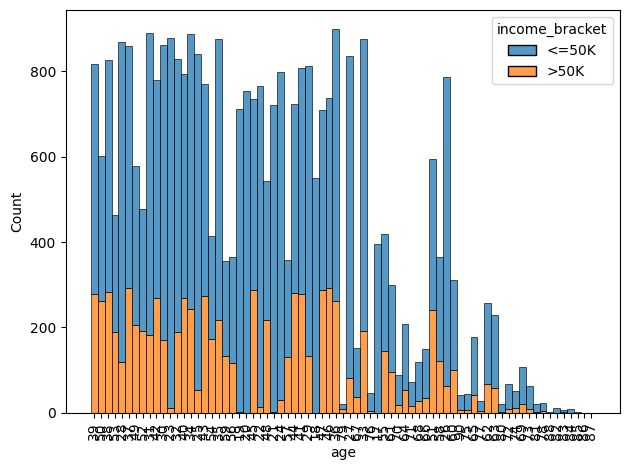

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


ax = sns.histplot(data=df_train, x='age', hue='income_bracket', multiple='stack')
ax.tick_params(axis='x', labelrotation=90)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn import preprocessing

X_num_train, X_cat_train, y_train = load_data(df=df_train)
X_num_test, X_cat_test, y_test = load_data(df=df_test)

y_lb = preprocessing.LabelBinarizer()
y_train = y_lb.fit_transform(y=y_train).astype(int).squeeze()
y_test = y_lb.transform(y=y_test).astype(int).squeeze()

num_scaler = preprocessing.StandardScaler()
X_num_train = num_scaler.fit_transform(X=X_num_train).astype('float32')
X_num_test = num_scaler.transform(X=X_num_test).astype('float32')
num_features = X_num_train.shape[1]

cat_encoder = preprocessing.OrdinalEncoder(unknown_value=-1,
    handle_unknown='use_encoded_value')
X_cat_train = cat_encoder.fit_transform(X=X_cat_train).astype(int) + 1
X_cat_test = cat_encoder.transform(X=X_cat_test).astype(int) + 1
cat_cardinalities = [len(c)+1 for c in cat_encoder.categories_]

In [ ]:
import torch
torch.manual_seed(seed=42)

class CensusDataset(torch.utils.data.Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(data=X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(data=X_cat, dtype=torch.long)
        self.y = torch.tensor(data=y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

ds_temp = CensusDataset(X_num=X_num_train, X_cat=X_cat_train, y=y_train)
ds_train, ds_val = torch.utils.data.random_split(dataset=ds_temp, lengths=[0.9, 0.1],
    generator=torch.Generator().manual_seed(42))
dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=256, shuffle=True)
dl_val = torch.utils.data.DataLoader(dataset=ds_val, batch_size=256, shuffle=False)

ds_test = CensusDataset(X_num=X_num_test, X_cat=X_cat_test, y=y_test)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, batch_size=256, shuffle=False)

In [ ]:
import torch
torch.manual_seed(seed=42)

class CensusClassifier(torch.nn.Module):
    def __init__(self, num_features, cat_cardinalities):
        super().__init__()
        self.embedding_layers = torch.nn.ModuleList(modules=[
            torch.nn.Embedding(num_embeddings=c,
                embedding_dim=int(min(8, max(1, round(c**0.25)))),
                padding_idx=0)
            for c in cat_cardinalities])

        in_features = num_features + sum(e.embedding_dim for e in self.embedding_layers)

        layers = []
        for h in [64, 32]:
            layers.append(torch.nn.Linear(in_features=in_features, out_features=h))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=0.3))
            in_features = h
        layers.append(torch.nn.Linear(in_features, 2))
        self.fc = torch.nn.Sequential(*layers)

    def forward(self, X_num, X_cat):
        X_emb = [emb(X_cat[:, i]) for i, emb in enumerate(self.embedding_layers)]
        X_emb = torch.cat(tensors=X_emb, dim=1)
        X = torch.cat(tensors=[X_num, X_emb], dim=1)
        return self.fc(X)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CensusClassifier(num_features=num_features, cat_cardinalities=cat_cardinalities)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', total_params)

In [ ]:
import torch
torch.manual_seed(seed=42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0.0, 0.0
    for X_num, X_cat, y in dataloader:
        X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)

        y_pred = model(X_num=X_num, X_cat=X_cat)
        loss = loss_fn(input=y_pred, target=y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=-1)==y).sum().item()
    train_loss /= len(dataloader)
    train_acc /= size
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for X_num, X_cat, y in dataloader:
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
            y_pred = model(X_num=X_num, X_cat=X_cat)
            test_loss += loss_fn(input=y_pred, target=y).item()
            test_acc += (y_pred.argmax(dim=-1)==y).sum().item()
    test_loss /= len(dataloader)
    test_acc /= size
    return test_loss, test_acc

In [ ]:
import numpy as np
import torch
torch.manual_seed(seed=42)

def train_model(model, dl_train, dl_val, loss_fn, optimizer,
        epochs, patience, save_path):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
        factor=0.5, patience=patience)

    best_val_loss = float('inf')

    history = {
        'train_loss': [], 'train_acc':[],
        'val_loss': [], 'val_acc': []
    }
    for epoch in range(epochs):
        train_loss, train_acc = train(dataloader=dl_train, model=model, loss_fn=loss_fn,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = test(dataloader=dl_val, model=model, loss_fn=loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step(val_loss)

        print("Epoch: %d, LR: %.3f, val_acc: %.3f"%(
            epoch, optimizer.param_groups[0]['lr'], val_acc))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    model.load_state_dict(torch.load(save_path, weights_only=True))
    return model, history

model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_val, loss_fn=loss_fn,
    optimizer=optimizer, epochs=10, patience=3, save_path='census_classifier_best.pth')